In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,n_actions)
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [3]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [5]:
class A2C_Agent():

    def __init__(self, n_steps, actor, critic, lr_actor, lr_critic):
        self.n = n_steps
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr_actor)
        self.critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)

    def choose_action(self, states):

        action_logits = self.actor.forward(states)
        state_values = self.critic.forward(states)

        actions_pd = torch.distributions.Categorical(logits=action_logits)
        actions = actions_pd.sample()
        actions_log_prog = actions_pd.log_prob(actions)

        return actions, actions_log_prog, state_values
    
    def get_losses(self, rewards, states, next_states, log_prob, gamma, terminated):

        R = torch.Tensor(rewards).reshape_as(self.critic(next_states)) + (1-torch.Tensor(terminated).reshape_as(self.critic(next_states))) * gamma * self.critic(next_states)
        A = R - self.critic(states)

        # print(torch.Tensor(rewards).reshape_as(self.critic(next_states)), self.critic(next_states))

        # advantage = (rewards) + (1-(terminated))*gamma*self.critic((next_states)) - self.critic((states))

        critic_loss = A.pow(2).sum() #should it be mean ? not in course
        # critic_loss = advantage.pow(2).mean()

        # print(A, log_prob, A.detach() * log_prob.reshape_as(A))
        actor_loss = -(A.detach() * log_prob.reshape_as(A)).sum() #minus sign ? not in slides
        # actor_loss = -log_prob*advantage.detach()

        return actor_loss, critic_loss
    
    def update_params(self, critic_loss, actor_loss):
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
    


In [5]:
env = gym.vector.AsyncVectorEnv([lambda: gym.make('CartPole-v1')]*1)
state = env.reset()[0]
state_dim  = env.single_observation_space.shape[0]
n_actions = env.single_action_space.n
actor = Actor(state_dim, n_actions)
state

array([[-0.00056651, -0.02930501,  0.01880272, -0.04240507]],
      dtype=float32)

In [6]:
env = gym.make("CartPole-v1")
state = env.reset()[0]
state_dim  = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions)
state
actor(state)

tensor([ 0.1391, -0.0898], grad_fn=<ViewBackward0>)

In [9]:
episode_rewards = []
env = gym.vector.AsyncVectorEnv([lambda: gym.make('CartPole-v1')]*1)
state_dim  = env.single_observation_space.shape[0]
n_actions = env.single_action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
agent = A2C_Agent(1, actor, critic, 1e-3, 1e-3)
state = env.reset()[0]
critic_losses = []
actor_losses = []

for i in range(500):
    total_reward = 0
    terminated = False
    while not terminated:
        actions, actions_log_prog, state_values = agent.choose_action(state)
        
        next_state, reward, terminated, truncated, _ = env.step(actions.numpy())
        actor_loss, critic_loss = agent.get_losses(reward, state, next_state, actions_log_prog, 0.99, terminated)
        total_reward += reward
        state = next_state

        agent.update_params(critic_loss, actor_loss)

        terminated = terminated.all()

        critic_losses.append(critic_loss)
        actor_losses.append(actor_loss)
            
    episode_rewards.append(total_reward)

In [10]:
episode_rewards

[array([26.]),
 array([39.]),
 array([80.]),
 array([55.]),
 array([98.]),
 array([53.]),
 array([36.]),
 array([25.]),
 array([20.]),
 array([22.]),
 array([23.]),
 array([21.]),
 array([19.]),
 array([19.]),
 array([19.]),
 array([19.]),
 array([16.]),
 array([22.]),
 array([20.]),
 array([22.]),
 array([18.]),
 array([18.]),
 array([17.]),
 array([29.]),
 array([30.]),
 array([20.]),
 array([24.]),
 array([28.]),
 array([34.]),
 array([65.]),
 array([37.]),
 array([47.]),
 array([35.]),
 array([36.]),
 array([41.]),
 array([92.]),
 array([102.]),
 array([44.]),
 array([60.]),
 array([38.]),
 array([36.]),
 array([51.]),
 array([52.]),
 array([73.]),
 array([115.]),
 array([101.]),
 array([17.]),
 array([12.]),
 array([10.]),
 array([9.]),
 array([8.]),
 array([10.]),
 array([9.]),
 array([10.]),
 array([10.]),
 array([10.]),
 array([8.]),
 array([10.]),
 array([8.]),
 array([10.]),
 array([9.]),
 array([11.]),
 array([9.]),
 array([10.]),
 array([8.]),
 array([9.]),
 array([8.]),
 a

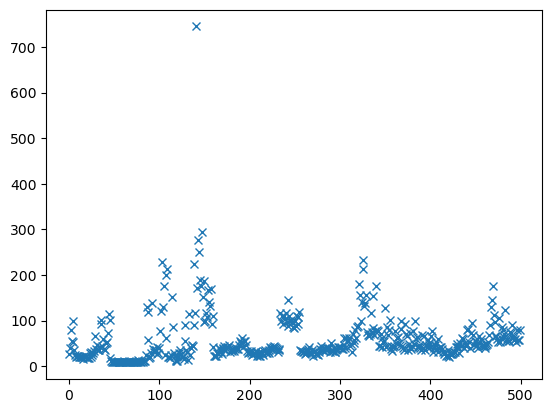

In [11]:

import matplotlib.pyplot as plt

ep = list(range(500))

plt.plot(ep, episode_rewards,'x')